This is a generic script for finetuning ViLT model for VQA tasks
Simply format your data as per the requirements below and this should work.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data format
* the images (stored in a single folder)
* the questions (stored in a JSON) -- with following
* the annotations (stored in a JSON) a.k.a. the answers to the questions.

Refer to https://github.com/multimodal/multimodal/blob/master/test/data/vqa2/val/v2_OpenEnded_mscoco_val2014_questions.json for a sample of how question json file should look like.

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00


In [3]:
import os
home = '/content/drive/MyDrive/ReadyForFineTuning/CLEVR_HYP/'
imroot = home+'images'
os.chdir(home)

This piece of code converts data in VLQAv1 into desired format. If multiple images are there, it automatically merges them into one.

In [4]:
prefix = 'clevr_hyp'

In [5]:
#!rm /content/blocksworld_truncated_viltft.jsonl

import json
import ast

dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "clevrhyp", "license": {}, "data_subtype": prefix,
    "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  for i in data:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    anslist = [str(i) for i in ast.literal_eval(ijson['answer_choices'])]
    #if len(imlist) == 2:
    #  mpath = mergeim(imlist[0], imlist[1])
    # mpath
    dumpdict['questions'].append( { "image_id": imroot+'/'+imlist[0].lstrip("./"), "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_viltft.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

Output hidden; open in https://colab.research.google.com to view.

### Read questions

First, we read the questions.

In [6]:
import json
f = open('/content/'+prefix+'_viltft.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 6250


That's quite a lot! Let's take a look at the first one:

In [7]:
questions[0]

{'image_id': '/content/drive/MyDrive/ReadyForFineTuning/CLEVR_HYP/images/CLEVR_val_000000.png',
 'question': 'How many spheres are there ? Add a blue metal sphere to the scene .',
 'question_id': 0,
 'answer_choices': ['Yes',
  'No',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  'Red',
  'Green',
  'Blue',
  'Yellow',
  'Purple',
  'Gray',
  'Cyan',
  'Brown',
  'Cube',
  'Sphere',
  'Cylinder',
  'Small',
  'Large',
  'Rubber',
  'Metal'],
 'answer_id': 4}

In [8]:
from os import listdir
from os.path import isfile, join

# -- CHANGE THIS BASED ON WHERE IMAGES ARE STORED --
#root = home+'images'

file_names = [f for f in listdir(imroot) if isfile(join(imroot, f))]
print(file_names)
print(len(file_names))

['CLEVR_val_004000.png', 'CLEVR_val_004001.png', 'CLEVR_val_004004.png', 'CLEVR_val_004006.png', 'CLEVR_val_004012.png', 'CLEVR_val_004011.png', 'CLEVR_val_004002.png', 'CLEVR_val_004010.png', 'CLEVR_val_004005.png', 'CLEVR_val_004003.png', 'CLEVR_val_004007.png', 'CLEVR_val_004009.png', 'CLEVR_val_004014.png', 'CLEVR_val_004022.png', 'CLEVR_val_004018.png', 'CLEVR_val_004008.png', 'CLEVR_val_004015.png', 'CLEVR_val_004013.png', 'CLEVR_val_004019.png', 'CLEVR_val_004017.png', 'CLEVR_val_004016.png', 'CLEVR_val_004021.png', 'CLEVR_val_004020.png', 'CLEVR_val_004029.png', 'CLEVR_val_004023.png', 'CLEVR_val_004028.png', 'CLEVR_val_004025.png', 'CLEVR_val_004026.png', 'CLEVR_val_004027.png', 'CLEVR_val_004024.png', 'CLEVR_val_004034.png', 'CLEVR_val_004035.png', 'CLEVR_val_004033.png', 'CLEVR_val_004036.png', 'CLEVR_val_004031.png', 'CLEVR_val_004030.png', 'CLEVR_val_004032.png', 'CLEVR_val_004042.png', 'CLEVR_val_004037.png', 'CLEVR_val_004040.png', 'CLEVR_val_004041.png', 'CLEVR_val_0040

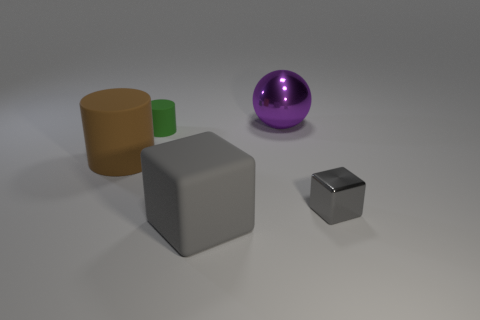

In [9]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [10]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

## Create PyTorch dataset

Next, we create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We leverage `ViltProcessor` to prepare each image + text pair for the model, which will automatically:
* leverage `BertTokenizerFast` to tokenize the text and create `input_ids`, `attention_mask` and `token_type_ids`
* leverage `ViltFeatureExtractor` to resize + normalize the image and create `pixel_values` and `pixel_mask`.

Note that the docs of `ViltProcessor` can be found [here](https://huggingface.co/docs/transformers/master/en/model_doc/vilt#transformers.ViltProcessor).

We also add the labels. This is a PyTorch tensor of shape `(num_labels,)` that contains the soft encoded vector.

In [ ]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor): #annotations
        self.questions = questions
        #self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # get image + text
        #annotation = self.annotations[idx]
        questions = self.questions[idx]
        #image = Image.open(id_to_filename[annotation['image_id']])
        image = Image.open(questions['image_id']).convert("RGB")
        text = questions['question']
        #print(image)
        #print(text)
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        #labels = questions['answer_choices'][questions['answer_id']] #annotation['labels']
        #scores = [1.0] #annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        #print(len(questions['answer_choices']))
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        #print(targets)
        #for label, score in zip(labels, scores):
        #      targets[label] = score
        encoding["labels"] = targets
        #print(encoding)
        #print(labels)
        #print(scores)

        return encoding

In [ ]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

In [ ]:
dataset = VQADataset(questions=questions,processor=processor) ##annotations=annotations[:10],

In [ ]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [ ]:
processor.decode(dataset[0]['input_ids'])

'[CLS] how many spheres are there? add a blue metal sphere to the scene. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()

## Define model

Here we define a `ViltForQuestionAnswering` model, with the weights of the body initialized from dandelin/vilt-b32-mlm, and a randomly initialized classification head. We also move it to the GPU, if it's available.

In [ ]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", num_labels=29)

model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.3.weight', 'classifier.0.bias', 'classifier.1.weight', 'classifier.0.weight', 'classifier.3.bias', 'classifier.1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  #print(pixel_values)
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  #encoding = processor.feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = torch.stack(pixel_values) #encoding['pixel_values']
  #batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

Let's verify a batch:

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([1, 40])
attention_mask torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
pixel_values torch.Size([1, 3, 384, 576])
labels torch.Size([1, 29])


## Train a model

Finally, let's train a model!

In [ ]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/6250 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Loss: 0.7183921337127686
Loss: 3.29036021232605
Loss: 2.5008931159973145
Loss: 3.0744423866271973
Loss: 0.5843378901481628
Loss: 2.8118929862976074
Loss: 3.090575695037842
Loss: 2.9223904609680176
Loss: 2.7322609424591064
Loss: 2.382750988006592
Loss: 2.889188766479492
Loss: 2.7366414070129395
Loss: 2.8050894737243652
Loss: 2.94429087638855
Loss: 2.8325488567352295
Loss: 0.6486807465553284
Loss: 2.6266558170318604
Loss: 2.736421823501587
Loss: 3.191469192504883
Loss: 9.330202102661133
Loss: 2.0628793239593506
Loss: 1.8960025310516357
Loss: 2.4482736587524414
Loss: 2.397942066192627
Loss: 2.823960542678833
Loss: 1.6117603778839111
Loss: 1.6819132566452026
Loss: 4.537715911865234
Loss: 2.7248902320861816
Loss: 2.0781614780426025
Loss: 2.0278398990631104
Loss: 2.653872489929199
Loss: 1.708796501159668
Loss: 2.6623318195343018
Loss: 3.3212051391601562
Loss: 3.5258355140686035
Loss: 2.559440851211548
Loss: 1.3511048555374146
Loss: 1.8921928

  0%|          | 0/6250 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Loss: 4.143253803253174
Loss: 2.5977511405944824
Loss: 2.683012008666992
Loss: 1.1033653020858765
Loss: 1.7411333322525024
Loss: 2.6636083126068115
Loss: 3.975263833999634
Loss: 1.7334986925125122
Loss: 2.583848714828491
Loss: 2.5997025966644287
Loss: 2.3729169368743896
Loss: 3.8038485050201416
Loss: 1.6677517890930176
Loss: 1.168313980102539
Loss: 1.6331653594970703
Loss: 2.5994205474853516
Loss: 2.598458766937256
Loss: 2.583756923675537
Loss: 4.749301433563232
Loss: 2.535029172897339
Loss: 1.5320132970809937
Loss: 2.5311813354492188
Loss: 2.4520835876464844
Loss: 2.692319869995117
Loss: 3.5643327236175537
Loss: 1.3480874300003052
Loss: 1.3491010665893555
Loss: 2.624285936355591
Loss: 2.521904945373535
Loss: 1.4614150524139404
Loss: 1.4568477869033813
Loss: 1.343574047088623
Loss: 2.77020001411438
Loss: 2.653700828552246
Loss: 1.352331519126892
Loss: 2.630295753479004
Loss: 2.3299403190612793
Loss: 1.4542925357818604
Loss: 1.334250807

  0%|          | 0/6250 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Loss: 2.8894941806793213
Loss: 3.2456398010253906
Loss: 2.517634630203247
Loss: 4.723049163818359
Loss: 2.523738145828247
Loss: 4.55190372467041
Loss: 3.2065021991729736
Loss: 4.479430675506592
Loss: 2.743220567703247
Loss: 3.1698148250579834
Loss: 2.751337766647339
Loss: 2.5254764556884766
Loss: 2.876758337020874
Loss: 2.871551990509033
Loss: 2.7375402450561523
Loss: 3.0323164463043213
Loss: 2.5290045738220215
Loss: 7.195591926574707
Loss: 3.184314489364624
Loss: 2.518186330795288
Loss: 3.080937623977661
Loss: 2.7327988147735596
Loss: 2.4940030574798584
Loss: 2.8502564430236816
Loss: 4.409885883331299
Loss: 2.7229068279266357
Loss: 2.4550464153289795
Loss: 2.439546585083008
Loss: 3.2079339027404785
Loss: 3.1272494792938232
Loss: 2.382935047149658
Loss: 2.360278844833374
Loss: 2.329284906387329
Loss: 3.1280171871185303
Loss: 3.11722731590271
Loss: 3.254673957824707
Loss: 2.219480037689209
Loss: 3.247617244720459
Loss: 3.230545997619629

  0%|          | 0/6250 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Loss: 2.6547863483428955
Loss: 3.1184215545654297
Loss: 2.194061517715454
Loss: 2.1911814212799072
Loss: 3.26631236076355
Loss: 3.267411708831787
Loss: 8.2870454788208
Loss: 2.173938035964966
Loss: 2.532121419906616
Loss: 3.321474075317383
Loss: 7.822303295135498
Loss: 3.2948741912841797
Loss: 3.295045852661133
Loss: 3.8342857360839844
Loss: 2.203819990158081
Loss: 3.3106882572174072
Loss: 3.0856781005859375
Loss: 3.080078125
Loss: 3.2127525806427
Loss: 3.7812037467956543
Loss: 3.7618567943573
Loss: 3.730557680130005
Loss: 2.278398036956787
Loss: 3.1745193004608154
Loss: 2.2904951572418213
Loss: 5.868719577789307
Loss: 2.7192769050598145
Loss: 2.7277908325195312
Loss: 2.7261667251586914
Loss: 2.3041305541992188
Loss: 5.106165885925293
Loss: 2.3012607097625732
Loss: 2.2946360111236572
Loss: 3.039217472076416
Loss: 3.438380718231201
Loss: 2.6918423175811768
Loss: 3.0376148223876953
Loss: 3.17875337600708
Loss: 3.0222156047821045
Loss: 3.

  0%|          | 0/6250 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Loss: 2.611569404602051
Loss: 2.2052197456359863
Loss: 2.8961479663848877
Loss: 2.5960958003997803
Loss: 3.569883108139038
Loss: 2.8914124965667725
Loss: 3.066701650619507
Loss: 2.5727086067199707
Loss: 3.071303606033325
Loss: 2.8742153644561768
Loss: 3.51338791847229
Loss: 3.5231263637542725
Loss: 3.5075275897979736
Loss: 2.5467722415924072
Loss: 2.8494837284088135
Loss: 3.4769654273986816
Loss: 3.471827983856201
Loss: 2.531748056411743
Loss: 4.4181013107299805
Loss: 2.3204615116119385
Loss: 3.060232639312744
Loss: 3.4110281467437744
Loss: 2.8251266479492188
Loss: 2.8189949989318848
Loss: 2.3644258975982666
Loss: 2.3673272132873535
Loss: 3.350433826446533
Loss: 2.780133008956909
Loss: 3.0696799755096436
Loss: 2.755699634552002
Loss: 2.3691399097442627
Loss: 2.3659002780914307
Loss: 3.4342615604400635
Loss: 5.307016849517822
Loss: 3.285585641860962
Loss: 2.346156597137451
Loss: 2.697436809539795
Loss: 2.3350887298583984
Loss: 3.0840084

## Inference

Let's verify whether the model has actually learned something:

# Single Instance Inference

In [ ]:
exid = 1
example = dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 7
Ground-truth answer: 10


# Batch Inference

In [27]:
import csv
tasktype = "29way"
filprefix = prefix+"_"+tasktype

count = 0
st = 0
end = 6250
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end):
    correctness = 0
    example = dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    #print([exid,predicted_class, gtclass,correctness])
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])
    acc = count*100/(end-st+1)

print(count)
print(end-st+1)
print(acc)

1130
6251
18.077107662773955
